In [30]:
import tensorflow as tf
import openpyxl as xl
import numpy as np
import matplotlib.pyplot as plt
import xlsxwriter
import re
import os

In [223]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [224]:
def import_data(path):
    wb = xl.load_workbook(path)
    sheet = wb.active
    dictionary = {}
    provinces = sheet['B']
    list_provinces = [[(province.column, province.row), province.value] for province in provinces[1:]]
    for (column, row), value in list_provinces:
        province = sheet.cell(row = row, column = column).value
        timeseries = []
        for cell in sheet[row][2:]:
            timeseries.append(cell.value)
        dictionary[province] = timeseries
    
    return dictionary

In [225]:
dataset = import_data('./completed_recap.xlsx')

In [226]:
time = np.arange(0, len(dataset["Lampung"]), 1)

In [229]:
series = dataset["DKI Jakarta"]

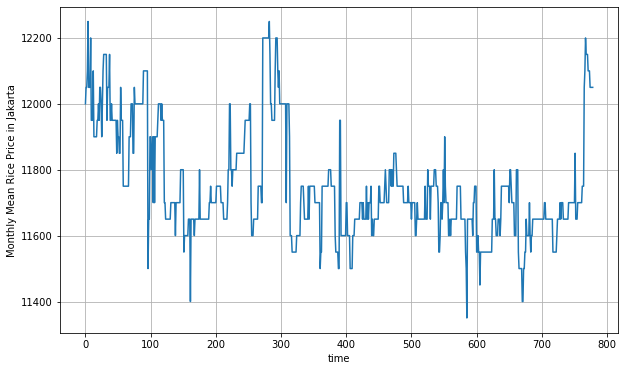

In [231]:
plot_series(time, series, xlabel='time', ylabel='Monthly Mean Rice Price in Jakarta')

In [232]:
# Define the split time
split_percentage = 0.7
split_time = round(split_percentage * len(time))

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [233]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [235]:
# Parameters
window_size = 24
batch_size = 32
shuffle_buffer_size = 100

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [236]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 1000)
])

 # Print the model summary 
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 24, 64)            256       
                                                                 
 lstm_33 (LSTM)              (None, 24, 64)            33024     
                                                                 
 lstm_34 (LSTM)              (None, 64)                33024     
                                                                 
 dense_57 (Dense)            (None, 30)                1950      
                                                                 
 dense_58 (Dense)            (None, 10)                310       
                                                                 
 dense_59 (Dense)            (None, 1)                 11        
                                                                 
 lambda_18 (Lambda)          (None, 1)               

In [237]:
# Get initial weights
init_weights = model.get_weights()

In [238]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
17/17 [==============================] - 4s 25ms/step - loss: 11854.4834 - lr: 1.0000e-08
Epoch 2/100
17/17 [==============================] - 0s 23ms/step - loss: 11848.3799 - lr: 1.1220e-08
Epoch 3/100
17/17 [==============================] - 0s 23ms/step - loss: 11843.4814 - lr: 1.2589e-08
Epoch 4/100
17/17 [==============================] - 0s 23ms/step - loss: 11837.8516 - lr: 1.4125e-08
Epoch 5/100
17/17 [==============================] - 0s 22ms/step - loss: 11831.5254 - lr: 1.5849e-08
Epoch 6/100
17/17 [==============================] - 0s 23ms/step - loss: 11824.4424 - lr: 1.7783e-08
Epoch 7/100
17/17 [==============================] - 0s 23ms/step - loss: 11816.5088 - lr: 1.9953e-08
Epoch 8/100
17/17 [==============================] - 0s 23ms/step - loss: 11807.6221 - lr: 2.2387e-08
Epoch 9/100
17/17 [==============================] - 0s 22ms/step - loss: 11797.6201 - lr: 2.5119e-08
Epoch 10/100
17/17 [==============================] - 0s 23ms/step - loss: 11786.2

17/17 [==============================] - 0s 22ms/step - loss: 883.1615 - lr: 1.0000e-04
Epoch 82/100
17/17 [==============================] - 0s 22ms/step - loss: 175.6630 - lr: 1.1220e-04
Epoch 83/100
17/17 [==============================] - 0s 22ms/step - loss: 554.6595 - lr: 1.2589e-04
Epoch 84/100
17/17 [==============================] - 0s 21ms/step - loss: 249.6867 - lr: 1.4125e-04
Epoch 85/100
17/17 [==============================] - 0s 22ms/step - loss: 135.7505 - lr: 1.5849e-04
Epoch 86/100
17/17 [==============================] - 0s 23ms/step - loss: 171.7671 - lr: 1.7783e-04
Epoch 87/100
17/17 [==============================] - 0s 22ms/step - loss: 139.2051 - lr: 1.9953e-04
Epoch 88/100
17/17 [==============================] - 0s 22ms/step - loss: 234.1557 - lr: 2.2387e-04
Epoch 89/100
17/17 [==============================] - 0s 22ms/step - loss: 199.7404 - lr: 2.5119e-04
Epoch 90/100
17/17 [==============================] - 0s 22ms/step - loss: 182.2982 - lr: 2.8184e-04
Epo

(1e-08, 0.001, 0.0, 1000.0)

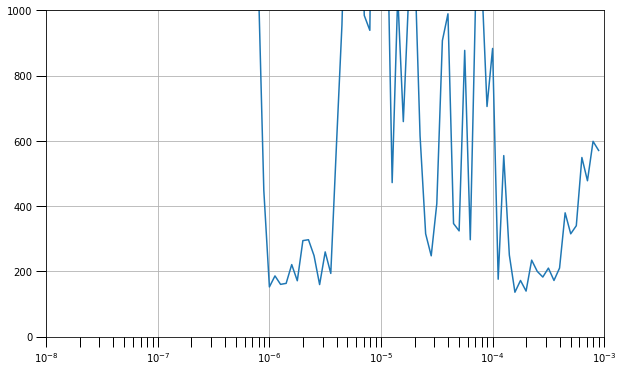

In [239]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 1000])

In [240]:
# Set the learning rate
learning_rate = 1.5849e-04

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [241]:
# Train the model
history = model.fit(train_set,epochs=200)

Epoch 1/200
17/17 [==============================] - 5s 26ms/step - loss: 171.6118 - mae: 172.1118
Epoch 2/200
17/17 [==============================] - 0s 24ms/step - loss: 142.3698 - mae: 142.8698
Epoch 3/200
17/17 [==============================] - 0s 24ms/step - loss: 226.5234 - mae: 227.0234
Epoch 4/200
17/17 [==============================] - 0s 24ms/step - loss: 204.2719 - mae: 204.7719
Epoch 5/200
17/17 [==============================] - 0s 24ms/step - loss: 145.7901 - mae: 146.2901
Epoch 6/200
17/17 [==============================] - 0s 23ms/step - loss: 158.7419 - mae: 159.2419
Epoch 7/200
17/17 [==============================] - 0s 25ms/step - loss: 172.5484 - mae: 173.0484
Epoch 8/200
17/17 [==============================] - 0s 26ms/step - loss: 152.0285 - mae: 152.5285
Epoch 9/200
17/17 [==============================] - 0s 25ms/step - loss: 139.5537 - mae: 140.0537
Epoch 10/200
17/17 [==============================] - 0s 24ms/step - loss: 179.2496 - mae: 179.7492
Epoch 11/

17/17 [==============================] - 0s 23ms/step - loss: 143.1899 - mae: 143.6899
Epoch 84/200
17/17 [==============================] - 0s 24ms/step - loss: 148.5029 - mae: 149.0027
Epoch 85/200
17/17 [==============================] - 0s 23ms/step - loss: 162.5259 - mae: 163.0259
Epoch 86/200
17/17 [==============================] - 0s 23ms/step - loss: 142.9093 - mae: 143.4061
Epoch 87/200
17/17 [==============================] - 0s 23ms/step - loss: 147.8905 - mae: 148.3905
Epoch 88/200
17/17 [==============================] - 0s 24ms/step - loss: 168.4614 - mae: 168.9610
Epoch 89/200
17/17 [==============================] - 0s 23ms/step - loss: 158.8883 - mae: 159.3883
Epoch 90/200
17/17 [==============================] - 0s 22ms/step - loss: 168.6222 - mae: 169.1222
Epoch 91/200
17/17 [==============================] - 0s 22ms/step - loss: 138.9863 - mae: 139.4863
Epoch 92/200
17/17 [==============================] - 0s 24ms/step - loss: 149.9398 - mae: 150.4398
Epoch 93/200


17/17 [==============================] - 0s 23ms/step - loss: 146.4525 - mae: 146.9515
Epoch 165/200
17/17 [==============================] - 0s 23ms/step - loss: 135.4035 - mae: 135.9031
Epoch 166/200
17/17 [==============================] - 0s 23ms/step - loss: 195.8265 - mae: 196.3255
Epoch 167/200
17/17 [==============================] - 0s 23ms/step - loss: 144.5092 - mae: 145.0092
Epoch 168/200
17/17 [==============================] - 0s 23ms/step - loss: 166.4944 - mae: 166.9944
Epoch 169/200
17/17 [==============================] - 0s 23ms/step - loss: 156.4633 - mae: 156.9633
Epoch 170/200
17/17 [==============================] - 0s 22ms/step - loss: 176.6554 - mae: 177.1548
Epoch 171/200
17/17 [==============================] - 0s 24ms/step - loss: 132.6404 - mae: 133.1404
Epoch 172/200
17/17 [==============================] - 0s 23ms/step - loss: 165.8777 - mae: 166.3777
Epoch 173/200
17/17 [==============================] - 0s 22ms/step - loss: 140.1585 - mae: 140.6585
Epoc

In [242]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

18/18 [==============================] - 0s 10ms/step


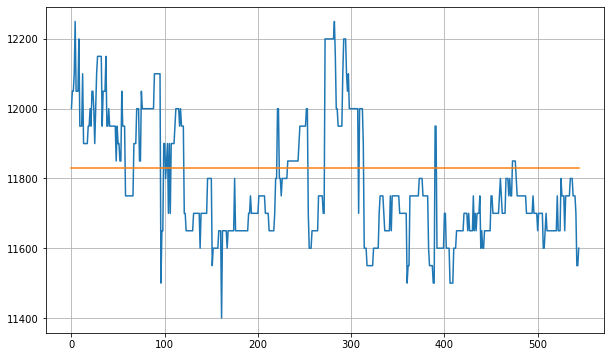

In [247]:
# Reduce the original series
forecast_series = series[window_size + 186:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_train, (x_train, results))